# [Montbrio SDE model using Numba](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/mpr_sde_numba.ipynb)

In [25]:
import os
import vbi
import torch
import warnings
import numpy as np
import pandas as pd
import networkx as nx
from copy import deepcopy
import sbi.utils as utils
from vbi.utils import timer
import multiprocessing as mp
import matplotlib.pyplot as plt
from vbi.models.numba.mpr import MPR_sde
from vbi.inference import Inference
%matplotlib inline

warnings.simplefilter("ignore")

In [23]:
seed= 42
np.random.seed(seed)

LABESSIZE = 10
plt.rcParams['axes.labelsize'] = LABESSIZE
plt.rcParams['xtick.labelsize'] = LABESSIZE
plt.rcParams['ytick.labelsize'] = LABESSIZE

path = "output/mpr_numba"
os.makedirs(path, exist_ok=True)

In [3]:
# @timer
def wrapper(g, par):
    par = deepcopy(par)
    sde = MPR_sde(par)
    control = {"G":g}
    data = sde.run(control)
    rv_t = data["rv_t"]
    rv_d = data["rv_d"]
    nn = par["weights"].shape[0]
    
    if par["RECORD_RV"]:
        r = rv_d[:, :nn]
        v = rv_d[:, nn:]
    
    bold_d = data["bold_d"]
    bold_t = data["bold_t"]
    
    if par["RECORD_RV"]:
        return rv_t, r, v, bold_t, bold_d
    else:
        return bold_t, bold_d

In [4]:
def plot(rv_t, r, v, bold_d, bold_t):
    step = 10
    fig, ax = plt.subplots(3, 1, figsize=(12, 6))
    ax[0].plot(rv_t[::step], r[::step, :], lw=0.1)
    ax[1].plot(rv_t[::step], v[::step, :], lw=0.1)
    ax[2].plot(bold_t, bold_d, lw=0.1)
    ax[0].set_ylabel("r")
    ax[1].set_ylabel("v")
    ax[2].set_ylabel("BOLD")

In [5]:
nn = 6
weights = nx.to_numpy_array(nx.complete_graph(nn))
params = {
    "G": 0.01,
    "weights": weights,
    "t_end": 10000,
    "dt": 0.01,
    "tau": 1.0,
    "eta": np.array([-4.6]),
    "rv_decimate": 10,  # in time steps
    "noise_amp": 0.037,
    "tr": 300.0,  # in [ms]
    "seed": 42,
    "RECORD_BOLD": True,
    "RECORD_RV": True,
}

warm up

In [6]:
rv_t, r, v, bold_t, bold_d =  wrapper(0.33, params)

In [7]:
# to check if there are any nans in the activities
np.isnan(r).sum()

0

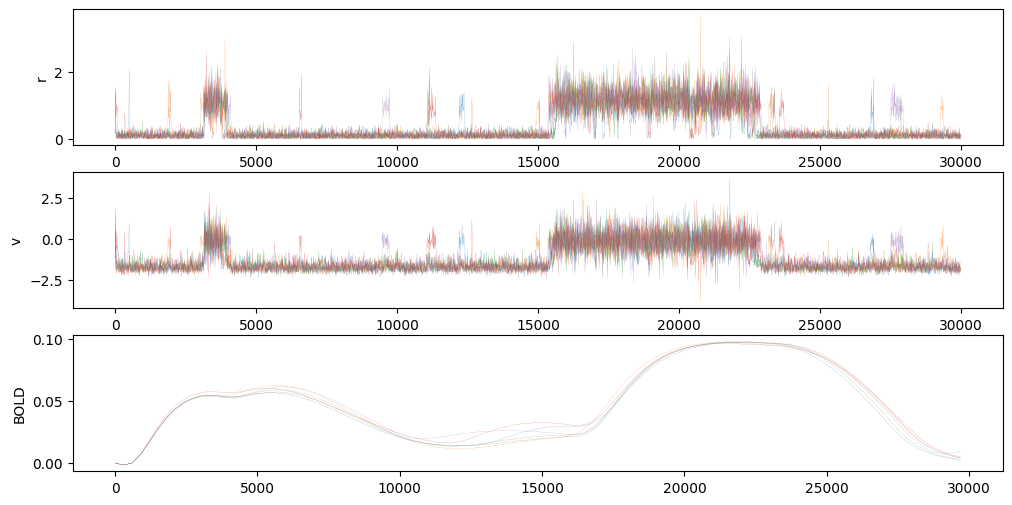

In [8]:
params['t_end'] = 30_000
g = 0.33
rv_t, r, v, bold_t, bold_d = wrapper(g, params)
plot(rv_t, r, v, bold_d, bold_t)

In [9]:
np.diff(rv_t)[:2], np.diff(bold_t[:2]), rv_t[0], rv_t[1], rv_t[-1]

(array([1., 1.], dtype=float32),
 array([300.], dtype=float32),
 0.0,
 1.0,
 29999.0)

- Sweeping over $G$.
- [use multiprocessing to speed up](https://github.com/Ziaeemehr/workshop_hpcpy/blob/main/notebooks/multiprocessing/note.ipynb).

In [10]:
g = np.linspace(0.3, 0.35, 4, endpoint=True)
with mp.Pool(processes=4) as p:
    results = p.starmap(wrapper, [(g_, params) for g_ in g])


In [11]:
len(results), len(results[0])

(4, 5)

In [12]:
# for i in range(4):
#     plot(results[i][0], results[i][1], results[i][2], results[i][4], results[i][3])

### Whole connectome

number of nodes: 88


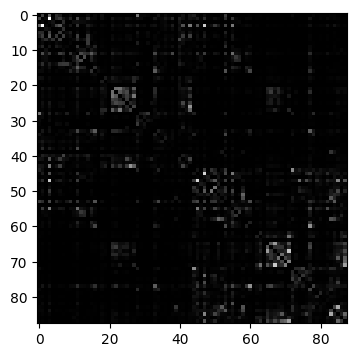

In [12]:
D = vbi.LoadSample(nn=88)
weights = D.get_weights()
nn = weights.shape[0]
print(f"number of nodes: {nn}")

fig, ax = plt.subplots(1, 1, figsize=(4, 4.5))
ax.imshow(weights, cmap="gray", vmin=0, vmax=1);

In [13]:
TR = 300.0
fs = 1 / (TR / 1000)
t_cut = 20
par = {
    "G": 0.506,  # global coupling strength
    "weights": weights,  # connection matrix
    "dt": 0.01,
    "t_cut": 20_000,
    "t_end": 100_000,  # [ms]
    "tr": TR,
    "rv_decimate": 10,
    "seed": seed,  
    "RECORD_RV": True,
    "RECORD_BOLD": True,
}

In [14]:
obj = MPR_sde(par)
sol = obj.run()

In [15]:
rv_d = sol["rv_d"]
rv_t = sol["rv_t"] / 1000
fmri_d = sol["bold_d"]
fmri_t = sol["bold_t"] / 1000

rv_d = rv_d
rv_t = rv_t
fmri_d = fmri_d
fmri_t = fmri_t
print(np.isnan(fmri_d).sum(), np.isnan(rv_d).sum())

print(f"rv_t.shape = {rv_t.shape}")
print(f"rv_d.shape = {rv_d.shape}")
print(f"fmri_d.shape = {fmri_d.shape}")
print(f"fmri_t.shape = {fmri_t.shape}")

0 0
rv_t.shape = (100000,)
rv_d.shape = (100000, 176)
fmri_d.shape = (333, 88)
fmri_t.shape = (333,)


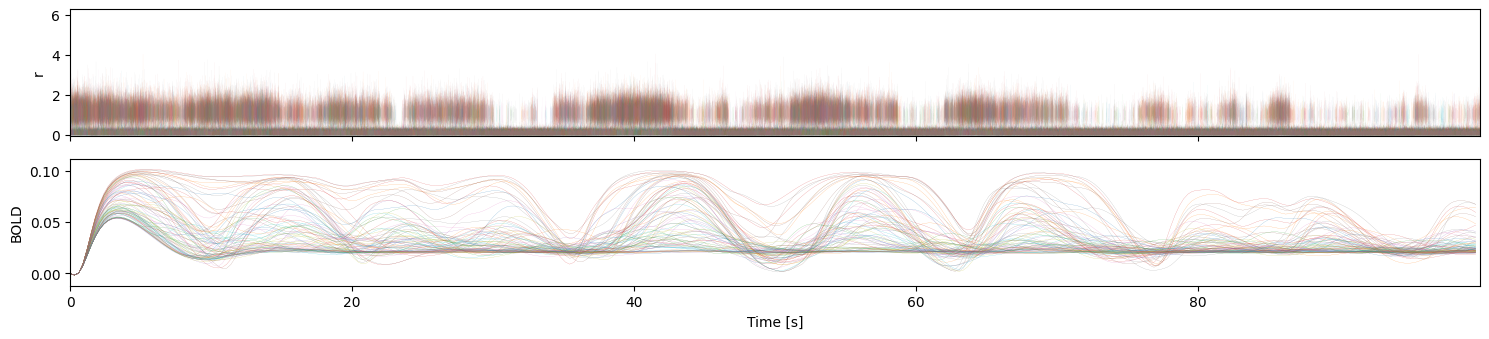

In [16]:
fig, ax = plt.subplots(2, figsize=(15, 3.5), sharex=True)
ax[1].set_ylabel("BOLD")
ax[1].plot(fmri_t, fmri_d[:,:], lw=0.1)
ax[1].margins(0, 0.1)
ax[0].plot(rv_t, rv_d[:, :nn], lw=0.1, alpha=0.1)
ax[0].set_ylabel("r")
ax[1].set_xlabel("Time [s]")
ax[0].margins(0, 0.01)
plt.tight_layout()
plt.show()


### Feature extraction

In [17]:
from vbi import (
    get_features_by_domain,
    get_features_by_given_names,
    report_cfg,
    extract_features,
)

cfg = get_features_by_domain("connectivity")
cfg = get_features_by_given_names(cfg, ["fcd_stat"])
report_cfg(cfg)



Selected features:
------------------
■ Domain: connectivity
 ▢ Function:  fcd_stat
   ▫ description:  Extracts features from dynamic functional connectivity (FCD)
   ▫ function   :  vbi.feature_extraction.features.fcd_stat
   ▫ parameters :  {'TR': 1.0, 'win_len': 30, 'positive': False, 'eigenvalues': True, 'masks': None, 'verbose': False, 'pca_num_components': 3, 'quantiles': [0.05, 0.25, 0.5, 0.75, 0.95], 'features': ['sum', 'max', 'min', 'mean', 'std', 'skew', 'kurtosis']}
   ▫ tag        :  ['fmri', 'eeg', 'meg']
   ▫ use        :  yes


In [18]:
df = extract_features([fmri_d.T], fs, cfg, n_workers=10, output_type="dataframe", verbose=False)
df = df[["fcd_full_sum", "fcd_full_ut_std"]]
df

,fcd_full_sum,fcd_full_ut_std
0,16099.71875,0.097014


In [19]:
num_sim = 200
G_min, G_max = 0.0, 1.0

prior_min = [G_min]
prior_max = [G_max]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

obj = Inference()
theta = obj.sample_prior(prior, num_sim, seed=seed)
theta_np = theta.numpy().squeeze()

In [20]:
theta_np.shape

(200,)

In [21]:
TR = 300.0
fs = 1 / (TR / 1000)
t_cut = 20
par = {
    "G": 0.506,  # global coupling strength
    "weights": weights,  # connection matrix
    "dt": 0.01,
    "t_cut": 20_000,
    "t_end": 100_000,  # [ms]
    "tr": TR,
    "rv_decimate": 10,
    "seed": seed,  
    "RECORD_RV": False,
    "RECORD_BOLD": True,
}

In [21]:
with mp.Pool(processes=10) as p:
    results = p.starmap(wrapper, [(g_, par) for g_ in theta_np])

In [22]:
bolds = [res[1].T for res in results]
bolds = np.array(bolds)
bolds.shape

(200, 88, 333)

In [23]:
df = extract_features(bolds, fs, cfg, n_workers=10, output_type="dataframe", verbose=True)
df.head(2)

100%|██████████| 200/200 [00:02<00:00, 69.61it/s]


,fcd_full_quantile_0.05,fcd_full_quantile_0.25,fcd_full_quantile_0.5,fcd_full_quantile_0.75,fcd_full_quantile_0.95,fcd_full_pca_sum,fcd_full_pca_max,fcd_full_pca_min,fcd_full_pca_mean,fcd_full_pca_std,...,fcd_full_eig_skew,fcd_full_eig_kurtosis,fcd_full_ut_sum,fcd_full_ut_max,fcd_full_ut_min,fcd_full_ut_mean,fcd_full_ut_std,fcd_full_ut_skew,fcd_full_ut_kurtosis,fcd_full_sum
0,-0.021312,-0.00909,0.003697,0.03069,0.700759,-2.842171e-14,3.802258,-2.59052,-3.116416e-17,1.609818,...,5.302009,28.855116,120.730682,0.352556,-0.060522,0.003205,0.025302,3.280647,20.693863,9331.612305
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
X = df[["fcd_full_sum", "fcd_full_ut_std"]].values
X = torch.as_tensor(X, dtype=torch.float32)

training NN and getting posterior

In [25]:
obj_inf = Inference()
posterior = obj_inf.train(theta, X, prior=prior, num_threads=4)

 Neural network successfully converged after 161 epochs.train Done in 0 hours 0 minutes 04.574155 seconds


In [26]:
torch.save(posterior, os.path.join(path, "posterior.pt"))
np.savez(os.path.join(path, "data.npz"), theta=theta_np, X=X.numpy())
df.to_csv(os.path.join(path, "features.csv"), index=False)

In [27]:
# loading data 
posterior = torch.load(os.path.join(path, "posterior.pt"), weights_only=False)
data = np.load(os.path.join(path, "data.npz"))
theta_np = data["theta"]
X = torch.as_tensor(data["X"], dtype=torch.float32)
df = pd.read_csv(os.path.join(path, "features.csv"))

plotting feature distributions

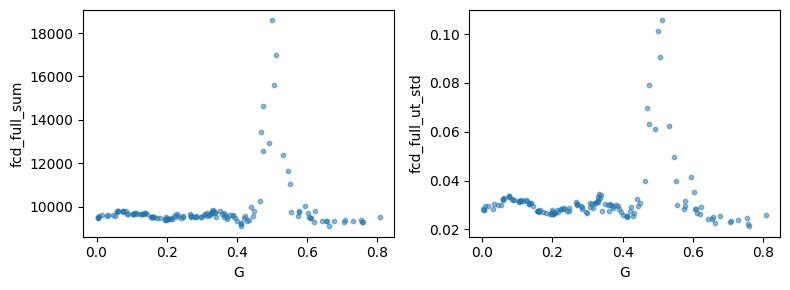

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].scatter(theta_np, X[:, 0], s=10, alpha=0.5)
ax[0].set_xlabel("G")
ax[0].set_ylabel("fcd_full_sum")
ax[1].scatter(theta_np, X[:, 1], s=10, alpha=0.5)
ax[1].set_xlabel("G")
ax[1].set_ylabel("fcd_full_ut_std")
plt.tight_layout()

1. choose a true value, 
2. simulate for given configuration, 
3. extract features from observation point 
4. sample from posterior given observation point
5. store data 

In [33]:
G_true = 0.5
bold_obs = wrapper(G_true, par)[1].T

# Check if there are any NaNs in the observed BOLD data
assert(np.isnan(bold_obs).sum() == 0)

x_obs = extract_features(
    [bold_obs], fs, cfg, n_workers=10, output_type="dataframe", verbose=False
)

x_obs = x_obs[["fcd_full_sum", "fcd_full_ut_std"]].values
samples = obj_inf.sample_posterior(x_obs, 5000, posterior)
torch.save(samples, os.path.join(path, "samples.pt"))

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

In [34]:
np.savez(os.path.join(path, "bold_obs.npz"), bold=bold_obs, G=G_true)

# data = np.load(os.path.join(path, "bold_obs.npz"))
# bold_obs = data["bold"]
# G_true = data["G"]
# samples = torch.load(os.path.join(path, "samples.pt"))

getting FC, FCD for visualisation

In [31]:
from vbi.feature_extraction.features_utils import get_fc, get_fcd 

fc = get_fc(bold_obs)['full']
fcd = get_fcd(bold_obs, win_len=25)['full']

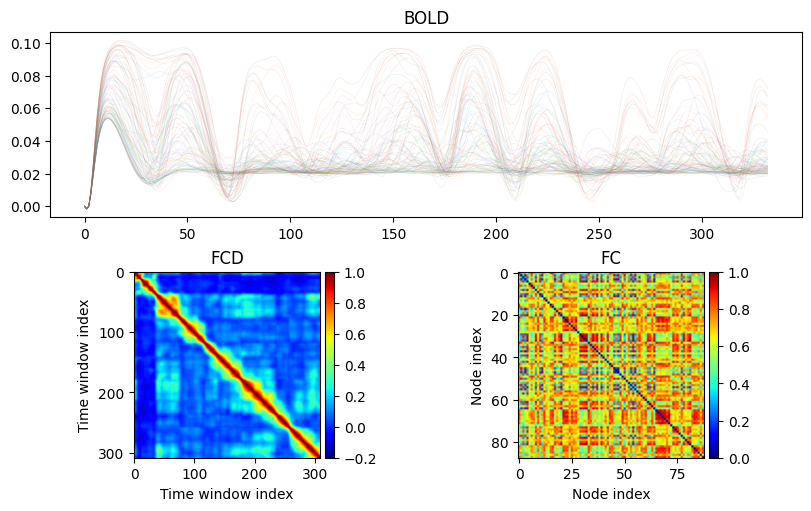

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

mosaic = """ 
AA
BC
"""
fig = plt.figure(constrained_layout=True, figsize=(8, 5))
ax_dict = fig.subplot_mosaic(mosaic)

# Plot data
ax_dict['A'].plot(bold_obs.T, lw=0.5, alpha=0.1)
im0 = ax_dict['B'].imshow(fcd, cmap="jet", vmin=-0.2, vmax=1)
im1 = ax_dict['C'].imshow(fc, cmap="jet", vmin=0, vmax=1)

divider0 = make_axes_locatable(ax_dict['B'])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
cbar0 = fig.colorbar(im0, cax=cax0)

divider1 = make_axes_locatable(ax_dict['C'])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax1)

# Set titles and labels
ax_dict['A'].set_title("BOLD")
ax_dict['B'].set_title("FCD")
ax_dict['B'].set_xlabel("Time window index")
ax_dict['B'].set_ylabel("Time window index")
ax_dict['C'].set_title("FC")
ax_dict['C'].set_xlabel("Node index")
ax_dict['C'].set_ylabel("Node index")

plt.show()


plotting posterior samples and comparing with true value in green.

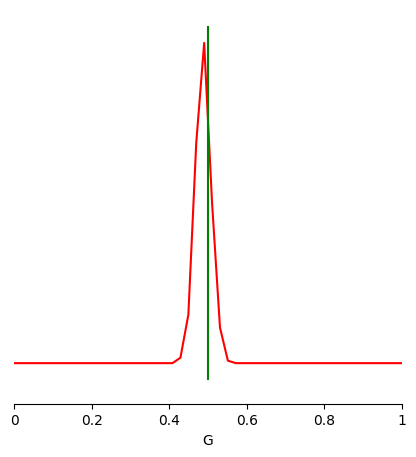

In [35]:
from sbi.analysis import pairplot

limits = [[i, j] for i, j in zip(prior_min, prior_max)]
fig, ax = pairplot(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=[G_true],
    labels=["G"],
    offdiag='kde',
    diag='kde',
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
    upper_kwargs={"mpl_kwargs": {"cmap": "Blues"}},
)

fig.savefig(path+"/G.png", dpi=150)